# Introduction

This notebook duplicates the data preprocessing and modelling that Chronos+ does, with all the database and job queue code stripped out. As far as possible, the duplication is verbatim to facilitate the transfer of any changes made in this notebook back into Chronos+. All current data rejection points are also documented.

## Imports

In [1]:
import logging
import math
import time
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as sts
from scipy.signal import argrelextrema

from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

%load_ext autoreload
# %autoreload 2
%reload_ext autoreload


%matplotlib inline
logging.getLogger().setLevel(logging.INFO)

Using TensorFlow backend.
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

## Define CSV filename, datetime and value columns

To test the modelling and scoring process on your own data, just change the following variables.

1. `datecol` --> the name of the column in the CSV file we wish to use as the time series index.
2. `ycols` --> the list of names of the value columns we wish to train and score on.
3. `fname` --> name of csv file.

In [2]:
datecol = "Time"
ycols = ["SA1900282"] # there can be more than one
fname = "data/giordano-oct-nov.csv"  # [ANDY] what's the prerequisite format of ts df (sample multivariate ts data)? can accommodate for ts1 = [0,30,60,90] and ts = [1,16,31,46]?

## Ingesting the data

1. `datecol` must exist in the CSV or we raise an exception
2. `ycols` must contain the name of at least one column or we raise an exception
3. every column in `ycols` must exist in the CSV or we raise an exception
4. if we cannot parse a value in the datetime column as a datetime, we discard the whole row
5. every value in the columns denoted by `ycols` is parsed as a float or set to np.nan
6. we set the `datecol` column as the index of the dataframe
7. we sort the dataframe by the index
7. we drop any columns not listed in `ycols` and return the result

In [3]:
class MissingColumnError(Exception):
    def __init__(self, col, *args, **kwargs):
        self.column = col
        Exception.__init__(self, *args, **kwargs)
        
def ingest(csv, dscol, ycols):
    """ ingests a timeseries csv. Does not throw an error if datetime format is not followed (will always try to interpret) or if value column contains non-int or non-floats.

    1) renames the datetime column to 'ds'

    2) indexes the 'ds' column

    3) sorts by ds column
    
    Parameters
    ----------
    csv : str 
         path to csv with header and format `datetime,value`.
         datetime: {%Y-%m-%d (e.g. 2017-12-01), 
                    %Y-%m-%d (e.g. 2017-12-1), 
                    %Y-%b-%d (e.g. 2017-Dec-01), 
                    %d-%b-%Y (e.g. 1-Dec-2017), 
                    %Y-%m-%d %H:%M:%S (e.g. 2017-12-01 00:00:00)}
                 * note all represent 1st December 2017
         value: {float, int}

    dscol : str
                    the header name for the datetime column in the csv
    ycols: list of str
                    the names of the value columns
    
    Returns
    -------
    pandas.DataFrame

    """
    df = pd.read_csv(csv)

    if dscol not in df:
        raise MissingColumnError(dscol)

    if not ycols:
        raise ValueError(f"ycols is empty: {ycols}")

    for ycol in ycols:
        if ycol not in df:
            raise MissingColumnError(ycol)

    # if the date column is not parseable as a date, then we should discard the row
    df[dscol] = pd.to_datetime(df[dscol], errors="coerce")
    df = df[~df[dscol].isnull()]

    # parse value column as float. no exceptions
    for ycol in ycols:
        df[ycol] = df[ycol].apply(__float_or_nan)  # [ANDY] can use pd.to_numeric(df[ycol], errors='coerce')

    df = df.set_index(dscol).sort_index()[ycols]
    return df.sort_index()  # [ANDY] redundant sort_index()?

def __float_or_nan(o):
    try:
        return np.float(o)
    except:
        return np.nan

In [4]:
df = ingest(fname, datecol, ycols)  # [ANDY] drop rows with unparseable ts but keep rows with NaN in ycols

## Autoencoder preprocessing

This is code that needs to be run regardless of whether we are preprocessing data for training or scoring. That is why it has been refactored into its own function.

1. remove duplicate rows (identical datetime and values)
2. if we find rows with identical datetime but different values, we raise an exception because it is impossible for us to decide which row contains the correct value.
  1. the other option is to delete all such rows, but for now we have elected to reject the entire CSV
3. we try to detect the sampling frequency of each value column
  1. we take the mode of the time differences between successive values for each column
  2. if there is no mode for any of the columns we reject the whole CSV
4. we return the resulting dataframe, along with the sampling frequencies for each column, as well as the minimum sampling frequency

In [5]:
def ae_preproc(df, ycols):
    """takes df, ycols and returns preprocessed df, freq"""
    df = remove_duplicate_rows(df)

    dupe_ds = list(df[df.index.duplicated()].index.drop_duplicates())  # [Andy] can use sum(df.index.duplicated())
    # we also reject if we have duplicate datetimes that are not duplicate rows
    if len(dupe_ds)!=0:
        raise Exception("rows with duplicate datetimes detected")

    colfreqs = {}
    for y in ycols:
        currdf = df[[y]].dropna()
        freqs = detect_ds_frequency(currdf)
        if len(freqs)!=1:
            # we reject if we have no modal sampling frequency
            raise Exception("more than one sampling frequency was detected")

        colfreqs[y] = freqs.index[0]

    minfreq = min(colfreqs.values())

    return df, colfreqs, minfreq

def remove_duplicate_rows(df):
    """returns df with duplicates removed 
    """    
    idx_name = df.index.name  # [ANDY] this is the same as dscol
    return df.reset_index().drop_duplicates().set_index(idx_name)

def detect_ds_frequency(df):
    """detects the frequency of datetime in df.
    
    1) subtract all the datetime in ds by its next datetime to retrieve the deltas
    
    2) count the number of occurrences for each delta
    
    Parameters
    ----------
    df : pandas.DataFrame 
         The dataframe to detect the datetime frequency, needs to have a sorted datetime index
    Returns
    -------
    freq : pd.Series of size 1 whose index is the modal timedelta and value is the number of times it appeared if there is one mode
    and it appeared > 50% of the time
           else pd.Series of max size 10 sorted by ascending order of modal timedeltas
    """
    deltas = pd.Series(df.index[1:] - df.index[:-1])  # [ANDY] deltas = df.reset_index()[dscol].diff()
    threshold = len(deltas)/2
    delta_counts = deltas.value_counts()
    modal_delta = delta_counts.idxmax()  # [ANDY] modal_delta = delta_counts.index[0]
    mdcount = delta_counts[modal_delta]  # mdcount = delta_counts.iloc[0]

    if mdcount > threshold:
        return delta_counts.head(1)

    dc = [item for item in delta_counts.iteritems()]
    # sort by ascending order of timedelta
    dc.sort(key=lambda e:e[0])
    # sort by descending order of occurrences
    dc.sort(key=lambda e:e[1], reverse=True)
    dc = dc[:50]

    return pd.Series(data=[e[1] for e in dc], index=[e[0] for e in dc])

In [6]:
df, colfreqs, minfreq = ae_preproc(df, ycols)  # [ANDY] df with no duplicated rows, no duplicated ts, with only one modal frequency for each column and with NaN

## Check for sparse columns

Given a duration _d_ and a time series with a sampling frequency _f_, the expected number of values it should have over _d_ is 

_e_ = _d_/_f_

We define a sparse column as a column within the dataframe where given its sampling frequency and the duration of the whole dataframe, it has less than 75% the number of expected values. We raise an exception if any column is sparse.

In [7]:
class SparseColumnError(Exception):
    pass

def check_sparse_cols(df, colfreqs):
    totalduration = df.index[-1] - df.index[0]
    for y, freq in colfreqs.items():
        numpoints = len(df[[y]].dropna())
        # every column must cover 75% of the duration
        expected = totalduration // freq * 0.75
        if numpoints < expected:
            raise SparseColumnError(f"column {y} has frequency {freq} and {numpoints} points, but duration of dataset is {totalduration}")

In [8]:
check_sparse_cols(df, colfreqs)

## Get period

We try to calculate the period of the data, but in order to keep things simple, we also require that the sampling frequencies of all the time series in the data (i.e. everything in `colfreqs`) be multiples of the minimum sampling frequency `minfreq`.

The method of detecting the period was deviced by Yiqun, and my understanding of it is not very firm. Nevertheless, I will try to explain the gist of what I know. Details will be skipped over in favour of conveying the overall idea because the details are in the code below.

First, we calculate the autocorrelation function for each time series in the data. We then add them all up and store them in `acfs`, aligning them using `minfreq`.

To illustrate, if we are given signals _a_ and _b_, with sampling frequencies 5 minutes and 10 minutes respectively, `minfreq` would be 5 minutes. Suppose we calculate the autocorrelation functions for each signal and the value at lag 2 for _b_ is `0.3` while the value at lag 4 for _a_ is `0.5`. `acfs[4]` would hence hold the value `0.8`.

After calculating `acfs` in this manner, we next obtain the indices of the local maxima within `acfs` and store it in `max_corr_points`. Then we take the absolute differences between every possible pair of indices in `max_corr_points`. Thus, we obtain a list of index differences between lags exhibiting high autocorrelation. The idea is that if the time series is periodic over _n_ time steps, then the autocorrelation will be high for lag _n_, _2n_, _3n_, ...

If we cannot find a period, we reject the data.

In [9]:
class NoPeriodError(Exception):
    pass

def get_period(df, colfreqs, minfreq):
    # check that all sampling frequencies are multiples of the smallest sampling frequency
    notime = pd.Timedelta(0)
    for f in colfreqs.values():
        if f % minfreq != notime:
            raise ValueError("detected sampling frequency that is not a multiple of the minimum sampling frequency")

    # there is no point calculating autocorrelation for lags greater than n/2
    nlags = len(df)//2  # [ANDY] assuming df covers at least two periods ? Why?
    acfs = np.zeros((nlags+1,))
    for y in colfreqs:
        yvals = df[y].dropna()
        yacfs = sts.acf(yvals, nlags=len(yvals)//2)
        step_size = colfreqs[y]//minfreq
        yacfs_idx = range(0, len(acfs), step_size)
        # we simplify by cropping because if len(df) % len(yvals) != step_size we get tedious off-by-one errors
        yacfs = yacfs[:len(yacfs_idx)]
        # if y has missing values, yacfs can be shorter than yacfs_idx -_-
        yacfs_idx = yacfs_idx[:len(yacfs)]
        acfs[yacfs_idx] += yacfs

    max_corr_points = argrelextrema(acfs, np.greater, order=max(len(df)//1000, 2))  # [ANDY] why max(len(df)//1000, 2))?
    max_corr_points = max_corr_points[0]
    max_corr_points = max_corr_points[acfs[max_corr_points]>0.2]  # [ANDY] why 0.2?
    max_corr_points = np.insert(max_corr_points, 0, 0, axis=0)
    max_cor_diff = []
    for point_1 in max_corr_points:
        for point_2 in max_corr_points:
            if point_1==point_2: continue
            max_cor_diff.append(abs(point_1-point_2))
    max_cor_diff = np.array(max_cor_diff)
    unique_vals, counts = np.unique(max_cor_diff, return_counts=True)
    adjust_counts = []
    for idx in range(len(unique_vals)):
        adjust_counts.append(np.sum(counts[np.where(unique_vals%unique_vals[idx]==0)]))
    if(np.max(adjust_counts)>5):  # [ANDY] why 5?
        return unique_vals[np.argmax(adjust_counts)]
    raise NoPeriodError("no period detected")

In [10]:
import matplotlib.pyplot as plt
period = get_period(df, colfreqs, minfreq)

/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


## Align data

This step tries to calculate the alignments for each column, in case there are misaligned values. The basic idea is as follows. Given a time series that starts at _t_ with sampling frequency _f_, you would expect there all the data to have a time index of _t + nf_, where _n_ is some positive integer. Any sequence of values that instead fall on _t + i + nf_, where _i_ is a non-zero value, is misaligned. 

Our approach is to first find groups of contiguous samples where _t + nf_ is true if we take the first time index in the group as _t_. Then we merge the non-contiguous groups based on whether they are aligned with each other. We assume that the largest such merged group is the one with the correct alignment and force every other group to align with it.

We then returned the aligned data as well as `zeropoint`, which is first time point of the aligned data, as well as `anchors`, which is the first time point of each column after alignment. The `anchor` and `zeropoint` values allow us to check if future CSVs belonging to the same time series are consistent with the training data. For scoring, we `align_data()` rejects the data if it is inconsistent with `anchors` after alignment.

In [11]:
class MisalignedColumnsError(Exception):
    pass

def align_data(df, colfreqs, minfreq, anchors=None, zeropoint=None):
    """aligns data according to sampling frequencies"""
    aligned_df = {}
    for y, freq in colfreqs.items():
        col_df = df[y].dropna()
        index_diff = col_df.index[1:]-col_df.index[:-1]
        sampling_groups = []
        cur_group = [col_df.index[0]]
        for idx in range(len(index_diff)):
            if (index_diff[idx]==freq):
                cur_group.append(col_df.index[idx+1])
            else:
                if (len(cur_group)>0):
                    sampling_groups.append(cur_group)
                cur_group = [cpdol_df.index[idx+1]]

        if (len(cur_group)>0):
            sampling_groups.append(cur_group)
            
        merged_sampling_group = []
        while len(sampling_groups)>0:
            cur_group = sampling_groups.pop(0)
            merged_idx = []
            for gidx, group in enumerate(sampling_groups):
                if ((group[0]-cur_group[-1])%freq==0):  # [ANDY] (group[0]-cur_group[-1])%freq == pd.Timedelta(0)?
                    cur_group.extend(group)
                    merged_idx.append(gidx)
        
            for m_idx in sorted(merged_idx, reverse=True):
                del sampling_groups[m_idx]
            
            merged_sampling_group.append(cur_group)
            
        merged_group_lens = [len(group) for group in merged_sampling_group]
        dominant_group_idx = np.argmax(merged_group_lens)
        init_group = merged_sampling_group[dominant_group_idx]
        
        n_samplings_before = round((init_group[0]-df.index[0])/freq)+1
        n_samplings_after = round((df.index[-1] - init_group[0])/freq)  # [ANDY] should +1?
        index_before = pd.date_range(end=init_group[0], periods = n_samplings_before, freq = freq, closed = 'left')
        index_after = pd.date_range(start=init_group[0], periods = n_samplings_after, freq = freq)
        aligned_index = index_before.append(index_after)
        
        # need to understand the mechanism of reindex on how it fill the NA value
        aligned_col_df = col_df.reindex(index=aligned_index, method='nearest', limit=1)
        aligned_df[y] = aligned_col_df
        
    aligned_df = pd.DataFrame(aligned_df)

    if anchors is None:
        anchors = {y:aligned_df[[y]].dropna().index[0] for y in colfreqs}
        #NOTE: the zeropoint value is necessary for building the time_index column, which fill_gaps does
        zeropoint = aligned_df.index[0]
    #if anchors is passed in, do a sanity check on alignment
    else:
        notime = pd.Timedelta(seconds=0)
        for y, yfreq in colfreqs.items():
            thisorigin = aligned_df[[y]].dropna().index[0]
            if (thisorigin - anchors[y]) % yfreq != notime:
                raise MisalignedColumnsError(f"after aligning the data, column {y}'s zero point {thisorigin} is not aligned with the recorded anchor point {anchors[y]} with sampling frequency {yfreq}")

    return aligned_df, anchors, zeropoint

In [12]:
df, anchors, zeropoint = align_data(df, colfreqs, minfreq)

## Drop extremes

Note that the period returned by `get_period()` is a positive integer. The actual period of the data in units of time is `period * minfreq`. For training, want to drop outlier values. Implementation details are in the code, but the basic idea is we label every row in `df` as a value within `range(0, period)`. Then for each column and each such label value, we calculate the mean and standard deviation of all the rows with that label, and those rows with values that exceed 2 standard deviations from the mean for that label are set to null.

### Example

Dataframe (period is _3_, sampling frequency is _f_, v is just a placeholder):

| time | value |
| --- | --- |
| _t_ | _v_ |
| _t+f_ | _v_ |
| t+2f | _v_ |
| _t+3f_ | _v_ |
| _t+4f_ | _v_ |
| t+5f | _v_ |

Dataframe with time index:

| time | value | time_index |
| --- | --- | --- |
| _t_ | _v_ | 0 |
| _t+f_ | _v_ | 1 |
| t+2f | _v_ | 2 |
| _t+3f_ | _v_ | 0 |
| _t+4f_ | _v_ | 1 |
| t+5f | _v_ | 2 |

In the example above, when deciding whether to set _v_ to null for _t+f_, we would consider the mean and standard deviation for the rows _t+f_ and _t+4f_.

In [13]:
def drop_extremes(df, freq, period, ycols):  # [ANDY] confirmed ts has been aligned, no need to fill ts gaps in this func again
    """drop values beyond 2 standard deviations from the mean"""
    # calculate the points where the gap is more than n_max_fill*interval
    time_between_points = df.index.to_series().diff()
    gaps = time_between_points[(time_between_points>=2*freq)]

    index_all = df.index
    for gidx, gap in gaps.iteritems():
        gap_length = math.ceil(gap/freq)
        padding = pd.date_range(end = gidx, periods = gap_length, freq = freq, closed = 'left')
        index_all = index_all.append(padding)

    index_all = index_all.sort_values()
    df = df.reindex(index_all)  # [ANDY] df is already aligned in last step, why there are still ts gaps to be filled?

    time_index = [i for i in range(0, period)]
    data_time_index = np.array([i % period for i in range(0, len(df))])
    data_time_index_series = pd.Series(index=index_all, data=data_time_index)

    n_std = 2

    for y in ycols:
        for period_idx in time_index:
            lbound = df[y][data_time_index_series==period_idx].mean()-n_std*df[y][data_time_index_series==period_idx].std()
            ubound = df[y][data_time_index_series==period_idx].mean()+n_std*df[y][data_time_index_series==period_idx].std()
        
            sub_data = df[y][data_time_index_series==period_idx]
            if (len(sub_data[(sub_data<lbound) | (sub_data>ubound)].index)>0):
                df.loc[sub_data[(sub_data<lbound) | (sub_data>ubound)].index, y] = None
    return df

In [14]:
df = drop_extremes(df, minfreq, period, ycols)

## Normalisation parameters

We did not previously normalise the data, but we noticed that columns with a larger range of values had a greater effect on anomaly scores, so we decided to make sure the values in every column fall between 0 and 1. Hence, we record the minimum and maximum values of the training data for each column. We reuse these mininum and maximum values when normalising future batches of data for scoring, because it is fine for scoring data to exceed these bounds so long as they are normalised with the same parameters.

Here we also add a `time_index` column to the dataframe.

In [15]:
# model normalisation params
modnorms = {y:( df[y].min(), df[y].max() ) for y in ycols}
df['time_index'] = [((t-zeropoint)//minfreq)%period for t in df.index]  # [ANDY] period is matched to minfreq? 

## Get median profiles

We calculate and store the median values for each column and time index. This information is used for filling gaps and also when scoring. This time index thing is calculated multiple times in different places. Sorry about that. -_-

In [16]:
def get_median_profiles(df, ycols, period):  # [ANDY] get median profiles after dropping extreme values?
    time_index = list(range(period))

    median_profiles = pd.DataFrame(index=time_index)

    for y in ycols:
        median_profiles[y] = [df[df['time_index']==t][y].median() for t in time_index]

    return median_profiles, time_index

In [17]:
median_profiles, time_index = get_median_profiles(df, ycols, period)

## Fill gaps

Since the input for the autoencoder has to be of fixed dimensions, we need to fill all the gaps in the data. We do this column by column. For small gaps, we do linear interpolation. For larger gaps, we use the median profiles.

In [18]:
def fill_gaps(df, colfreqs, minfreq, period, median_profiles, zeropoint):
    df = df.copy()

    firstts = df.index[0]
    lastts = df.index[-1]
    for y, yfreq in colfreqs.items():
        yfactor = yfreq//minfreq
        yperiod = period//yfactor
        ydf = df[[y]].dropna()  # [ANDY] df already aligned.. if don't dropna, df[[y]] is already alighed with correct ts, just need to fill value gaps instead of ts gaps
        ydf, gaps = gap_reindex(ydf, yfreq, firstts, lastts)  # [ANDY] why still need to fill index(ts) gaps?
        ydf['time_index'] = [((t-zeropoint)//minfreq)%period for t in ydf.index]
        ydf = fill_gaps_col(ydf, y, gaps, yfreq, yperiod, median_profiles)
        newindex = ydf.index.union(df.index).sort_values()  # [ANDY] redundant, index is already aligned
        df = df.reindex(newindex)  # [ANDY] redundant, index is already aligned
        df[y] = ydf[y]

    df['time_index'] = [((t-zeropoint)//minfreq)%period for t in df.index]
    return df

def gap_reindex(df, freq, firstts, lastts):
    # calculate the points where the gap is more than n_max_fill*freq
    # these points don't want to interpolate
    time_between_points = df.index.to_series().diff()

    # if first timestamp for this column is not equal to first timestamp for all columns, we need to fill
    yfirstts = df.index[0]
    if yfirstts!=firstts:
        time_between_points.at[yfirstts] = yfirstts - firstts + freq

    # if last timestamp for this column is not equal to last timestamp for all columns, we need to fill
    ylastts = df.index[-1]
    if ylastts!=lastts:
        time_between_points.at[lastts+freq] = lastts - ylastts + freq

    gaps = time_between_points[(time_between_points>=2*freq)]

    index_all = df.index
    padded_indices = pd.date_range(end = min(index_all), periods = 0, freq = freq, closed = 'left')  # [ANDY] why this?
    # create index positions for gaps
    for gidx, gap in gaps.iteritems():
        gap_length = math.ceil(gap/freq)
        padding = pd.date_range(end = gidx, periods = gap_length, freq = freq, closed = 'left')
        padded_indices = padded_indices.union(padding)  # [ANDY] why this?
        index_all = index_all.append(padding)

    index_all = index_all.sort_values()

    df = df.reindex(index_all)
    return df, gaps

def fill_gaps_col(df, y, gaps, freq, period, median_profiles):
    # interpolate large gaps using median values
    max_miss_length = period//10
    for gidx, gap in gaps.iteritems():
        if (gap>max_miss_length*freq):
            gap_length = math.ceil(gap/freq)
            n_periods = 2
            while (n_periods<=gap_length):
                pre_index = pd.date_range(end = gidx, periods = n_periods, freq = freq, closed = 'left')
                pre_index = pre_index[0]

                df.loc[pre_index, y] = median_profiles.loc[df.loc[pre_index, "time_index"], y]

                n_periods = n_periods+1

    # small gaps interpolated linearly
    return df.interpolate(method='linear', limit_direction="both")

In [19]:
df = fill_gaps(df, colfreqs, minfreq, period, median_profiles, zeropoint)

## Test for pipeline
Call a pipeline class to execute preprocessing functions one by one.


In [20]:
#test for pipeline
from preprocessing._preprocessor import LoadData, FindFrequency, PeriodDetect, AlignData, DropExtrema, Normalizer, FillGap
from pipeline import Pipeline

test_task_list = [LoadData(), FindFrequency(), PeriodDetect(), AlignData(), DropExtrema(), Normalizer(), FillGap()]
test_pipeline = Pipeline(test_task_list)
df3, params3 = test_pipeline.fit_transform()

print(df3.equals(df))
colfreqs3 = params3['colfreqs']
is_equal = colfreqs3 == colfreqs
print(is_equal)
print(minfreq == params3['minfreq'])
print(period == params3['period'])
print(zeropoint == params3['zeropoint'])
print(anchors == params3['anchors'])

period_detect正在检查
align_data正在检查
drop_extrema正在检查
normalizer正在检查
fill_gap正在检查
True
True
True
True
True
True


## Model metadata

This part is a bit of engineering detail. It is used for persisting some of the metadata required to create the model. Some names are weird because of the legacy of having to train multiple autoencoders previously.

In [21]:
t = time_index[-1]
t_to_fname = {t: f"model-params.h5"}
inputsize = sum(period//(freq//minfreq) for freq in colfreqs.values())
modelmeta = {"median_profiles": median_profiles, "input_size":inputsize, "t_to_fname": t_to_fname, "modnorms": modnorms}
modfname = t_to_fname[t]

## Get full periods of data for training

In [22]:
# get times within df corresponding to t in period that can yield a full period of training data
# i.e. time - period >= df.index[0]
fullperiods = df.iloc[period:]  # [ANDY] why? should be period-1
times = fullperiods[fullperiods['time_index']==t].index

## Generate model input

We use the same function to generate model inputs for both training and scoring.

### Shifting the data

Originally, we used to train `period` number of autoencoders for each set of data, because we thought we needed to remember `period` number of patterns. Basically, if the period is 3, then every point in the data is labelled [0, 1, 2, 0, 1, 2, ...]. Hence there are 3 different patterns we needed to remember. The one with all the windows of data from [0,1,2], the one with all the windows of data from [1,2,0], and the one with all the windows of data from [2,0,1]. Later, we realised that we were actually training a bunch of different models that remember the same pattern, just at different phases of the period. So we started to train only one model that remembered the pattern of data for the window from [0,1,2]. When we needed to score data for a [2,0,1] window, we just left shifted it by one position before sending it to the autoencoder. To see how we do this, see how `startpos` is calculated and used in the code below.

### Normalise the data

This is fairly straightforward.

### Handling multiple columns

To handle multiple columns with a single autoencoder, we just concatenate all the columns. As long as the relative positions of the columns are preserved and the input dataframe has already been aligned, we can always unpack the autoencoder output in the same way. The autoencoder has no concept of different columns in any case.

### Differences between training and scoring

We train the model with the data in `df` as is.

For scoring, we pass in `median_values`, which is the `median_profiles` we calculated earlier. Supposing the period and therefore width of the input to the model is 100, we basically only pass the last 10 points of real data into the model and replace the rest of the window with the median values for each point in the period. Hence when we generate the anomaly scores for the window ending at point _t_, we are basically asking the model the following question.

Given the assumption that points _t-99 - t-10_ are normal, what is the chance that _t-9 - t_ is abnormal?

In [23]:
def normdf(df, modnorms):
    normed = df.copy()
    for y, ( ymin, ymax ) in modnorms.items():
        mmdiff = ymax - ymin
        normed[y] = (normed[y]-ymin)/mmdiff
    return normed

def generate_model_input(df, ycols, times, period, modnorms, offset=None, median_values=None):
    """
generate model input for windows ending at timestamps in the times arguments

Assumptions:
    1. times all have the same time index relative to period
    2. sampling intervals for each column are regular
    """
    offset = period-1 if offset is None else offset
    window_size = 10
    rows = []
    for t in times:
        idx = df.index.get_loc(t)+1
        rowdf = df.iloc[idx-period:idx].copy()
        if median_values is not None and window_size<period:
            replaceidx = rowdf.iloc[:len(rowdf)-window_size].index
            rowdf.loc[replaceidx, ycols] = median_values.loc[rowdf.loc[replaceidx, "time_index"], ycols].to_numpy()
        # normalize training/scoring data
        rowdf = normdf(rowdf, modnorms)
        startpos = period-1-offset
        rowdf = rowdf.iloc[startpos:].append(rowdf.iloc[:startpos])  # [ANDY] why?
        row = np.concatenate([rowdf[y].dropna() for y in ycols])
        rows.append(row)

    collens = set(len(r) for r in rows)
    if len(collens)!=1:
        logging.error(f"detected row lengths: {collens}")
        raise MisalignedColumnsError("unable to create input data because dimensions don't match")

    numcols = collens.pop()

    return np.concatenate(rows).reshape(( -1, numcols ))

In [24]:
dat = generate_model_input(df, ycols, times, period, modnorms)
print(dat.shape)
print(dat.size)

(59, 48)
2832


## Training the model

I am assuming the person who reads this will be more familiar with this part than I am, so I am not going to say much here. It is a just a basic autoencoder.

In [25]:
def train_model(data, weight_filename):
    timelimit = 5400 # 1.5 hours
    starttime = time.time()

    not_overtime = lambda t: t-starttime<timelimit

    logend_cb = LogEndCallback()
    n_inputs = data.shape[1]

    # we record 30 errors for averaging. if average of 30 errors is not decreasing,
    # we stop training
    ave_step = 30
    past_err_store = np.array([0.0 for i in range(ave_step)])
    nextpos = logend_cb.runs % ave_step
    prev_average_err = None

    model = construct_ae_model(n_inputs)
    model = learn_ae_model(model, data, logend_cb)
    
    test_error = np.sum(np.square(data - model.predict(data)))
    sumsquare = np.sum(np.square(data))

    while (test_error/sumsquare>0.001) and not_overtime(time.time()):  # [ANDY] why 0.001? not consistent with the scale factor used in defining early stoppping baseline
        print(logend_cb.runs)
        nextpos = logend_cb.runs % ave_step
        model = learn_ae_model(model, data, logend_cb)
        
        test_error = np.sum(np.square(data - model.predict(data)))
        if logend_cb.runs % 10 == 0:
            logging.info(f"runs = {logend_cb.runs}, sumsquare = {sumsquare}, test_error = {test_error} for {weight_filename}.")

        past_err_store[nextpos] = test_error
        if nextpos == ave_step-1:
            average_err = past_err_store.mean()
            if prev_average_err is not None and average_err>=prev_average_err: 
                logging.info(f"stopping because previous average error {prev_average_err} is smaller than current average error {average_err}")
                break
            if prev_average_err is not None:
                logging.info(f"training {weight_filename} errs: {past_err_store}\naverage of old errors: {prev_average_err}. average of new errors: {average_err}")
            prev_average_err = average_err

    logging.info("saving {}".format(weight_filename))
    model.save_weights(weight_filename)
    K.clear_session()

class LogEndCallback(Callback):
    def __init__(self):
        self.runs = 0

    def on_train_end(self, logs=None):
        self.runs += 1
        
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                logging.debug("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def construct_ae_model(n_inputs):
    n_units_1 = math.floor(n_inputs/2)#max(math.floor(n_inputs/4), 30)
    n_units_2 = math.floor(n_units_1/2)#max(math.floor(n_units_1/4), 15)
    # define model
    ae_model = Sequential()
    ae_model.add(Dense(n_units_1, activation='relu', input_shape=(n_inputs,)))
    ae_model.add(Dense(n_units_2, activation='relu', input_shape=(n_units_1,)))
    ae_model.add(Dense(n_units_1, activation='relu', input_shape=(n_units_2,)))
    ae_model.add(Dense(n_inputs, activation='linear'))
    ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    return ae_model

def learn_ae_model(ae_model, data, logend_cb):
    batch_size = 32
    #mean_norm = np.mean(np.square(data.values.reshape(data.shape[0], -1)))
    mean_norm = np.mean(np.square(data))
    baseline = mean_norm/10000.0
    logging.debug('baseline=' + str(baseline))
    
    # fit model
    loss_cb = EarlyStoppingByLossVal(monitor='val_loss', value=baseline)
    ae_model.fit(data, data, validation_data=(data, data), epochs=200, callbacks=[loss_cb, logend_cb], batch_size=batch_size, shuffle=True, verbose=0)
    
    return ae_model

In [26]:
train_model(dat, modfname)

1
2
3
4
5
6
7
8


INFO:root:saving model-params.h5


## New training model using PyTorch

In [27]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms, datasets, models
import visdom
import time


#AE structure
class AutoEncoder(nn.Module):
    def __init__(self, first_layer, layer_1, layer_2):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(first_layer, layer_1),
            nn.ReLU(),
            
            nn.Linear(layer_1,layer_2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(layer_2, layer_1),
            nn.ReLU(),
            
            nn.Linear(layer_1, first_layer)            
        )

    def forward(self, x):
        
        x_encoder = self.encoder(x)
        x_decoder = self.decoder(x_encoder)

        return x_encoder,x_decoder
    
#custom dataset
class ChronosDataset(Dataset):
    def __init__(self,dat):
        self.dat = dat
        
    def __len__(self):
        return len(self.dat)
    
    def __getitem__(self,idx):
        return self.dat[idx]

#Trainning function
def _fit(ae, train_loader, epochs,optimizer,loss_f):
    for epoch in range(epochs):
        for batchidx, x in enumerate(train_loader):
            #print(x.size())
            x = Variable(x.float())
            _x_encoded, _x_decoded = ae(x.float())
            loss = loss_f(_x_decoded,x)
    #         test_error = np.sum(np.square(data - model.predict(data)))
    #         sumsquare = np.sum(np.square(data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()



In [29]:
#trainning process
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 200
AVE = 30

df_loader = ChronosDataset(dat)

train_loader = DataLoader(df_loader, BATCH_SIZE, True)

first_layer = dat.shape[1]
layer_1 = max(math.floor(first_layer/4),30) #max(math.floor(n_inputs/4), 30)
layer_2 = max(math.floor(layer_1/4),15) #max(math.floor(n_units_1/4), 15)

ae = AutoEncoder(first_layer, layer_1, layer_2)
optimizer = torch.optim.Adam(ae.parameters(), lr=LR)
loss_f = nn.MSELoss()

continue_flag = True
#it will just continue training forever if loss is stilling improving
while continue_flag:
    average_times = 30
    average_loss =0.0
    previous_loss = 0.0
    #train 30 times, each time 200 epoch, calculate average_loss and compare with the 30th loss, average is actually larger then training will stop
    #if (previous_loss / sumsquare) < 0.001 then a good result is achieved? Need to learn more here.
    for i in range(average_times):
        _fit(ae,train_loader,EPOCHS,optimizer,loss_f)
        _dat = torch.from_numpy(dat)
#         print(_dat.size())
#         print(type(_dat))
        _dat = Variable(_dat.float())
        _code,_pred = ae(_dat)
#         print(type(_pred))
#         print(_pred.size())
        previous_loss = np.sum(np.square(_dat.detach().numpy() - _pred.detach().numpy()))
        sumsquare = np.sum(np.square(dat))  
#         print(previous_loss)
#         print(sumsquare)
        average_loss += previous_loss
        if (previous_loss / sumsquare) < 0.001:
            continue_flag = False
            break
        if i == average_times - 1:
            average_loss = average_loss / average_times
            
    if average_loss > previous_loss:
        continue_flag = False


## Ingest and preprocess data for scoring

A lot of this is similar to preparing the training data, the main differences are that

1. We do not remove outliers.
2. We need to leftpad the data with the median_profiles so that we can generate scores for the first time point in the actual data.

Note that some of the following cells overwrite existing variable names, so rerunning preceding cells will yield inconsistent results.

To score other files, simply change the value of `scorefname` below.

In [30]:
def leftpad(df, ycols, minfreq, period, profile):
    """leftpads dataframe by period-1 points with median values for each column"""
    df = df.copy()

    firstindex = df['time_index'][0]
    leftpad_index = [i%period for i in range(firstindex - (period - 1), firstindex)]
    dat = {y:[profile.loc[i][y] for i in leftpad_index] for y in ycols}
    dat['time_index'] = leftpad_index
    leftdf = pd.DataFrame(
        data = dat,
        index = pd.date_range(end=df.index[0], periods=period, freq=minfreq, closed='left'))
    df = leftdf.append(df)

    return df

In [35]:
scorefname = fname # substitute to score different data
df = ingest(scorefname, datecol, ycols)
df, _, _ = ae_preproc(df, ycols)
original_data = df.copy() # saved because we might need it later

aligned, _, _ = align_data(original_data, colfreqs, minfreq, anchors, zeropoint)
aligned['time_index'] = [((t-zeropoint)//minfreq)%period for t in aligned.index]
df = leftpad(aligned, ycols, minfreq, period, median_profiles)
df = fill_gaps(df, colfreqs, minfreq, period, median_profiles, zeropoint)
test_seq = aligned.copy()
nona = test_seq.dropna(how="all")

## Load model for scoring

In [32]:
model = construct_ae_model(modelmeta['input_size'])
model.load_weights(modfname)

## Actual scoring

Here we score the data in batches. Each batch is all the windows from one phase in the period.

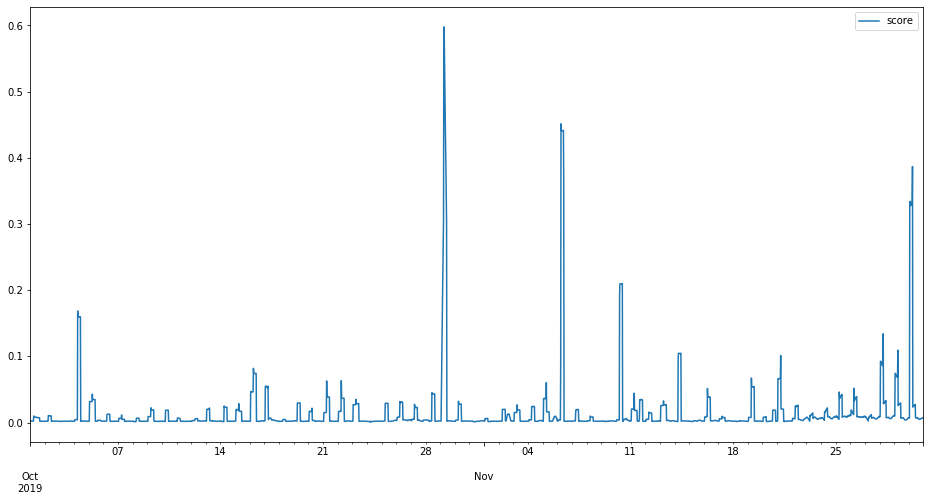

In [33]:
for t in time_index:
    times = nona[nona['time_index']==t].index
    signals = generate_model_input(df, ycols, times, period, modnorms, offset=t, median_values=median_profiles)
    preds = model.predict(signals.reshape([signals.shape[0], -1]))
    errors = np.sum(np.square(signals-preds), axis=1)
    test_seq.loc[times, 'score'] = errors
    #logging.info(f"finished scoring window {t}")

K.clear_session()

test_seq[['score']].plot(figsize=[16,8])

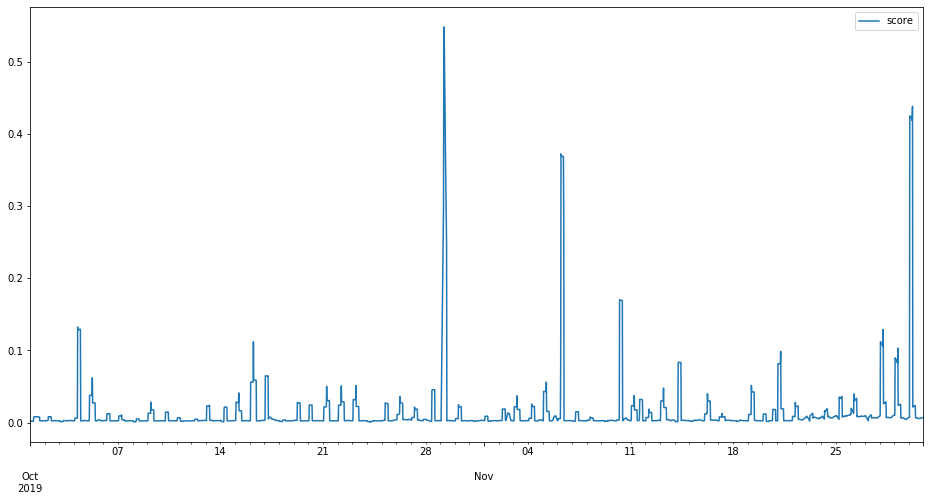

In [36]:
for t in time_index:
    times = nona[nona['time_index']==t].index
    signals = generate_model_input(df, ycols, times, period, modnorms, offset=t, median_values=median_profiles)
    _signals = signals.reshape([signals.shape[0], -1])

    _signals = torch.from_numpy(signals)
#     print(_signals.size())
#     print(type(_signals))
    signals = Variable(_signals.float())
    code,preds = ae(signals)
#     print(type(preds))
#     print(preds.size())
    errors = np.sum(np.square((signals-preds).detach().numpy()), axis=1)
    test_seq.loc[times, 'score'] = errors
    #logging.info(f"finished scoring window {t}")

K.clear_session()

test_seq[['score']].plot(figsize=[16,8])

## Zoomed in views

This has nothing to do with modelling, really. In actual deployment, we allow the users to pick a point _t_ in time and look at the actual data and the values reconstructed by the autoencoder so that they can decide whether or not it was an anomaly. There are two parts to this.

1. Run the model on the window of 1 period ending at _t_ to generate the outputs. This is mostly the same process as in scoring.
2. Reconstruct the autoencoder output (basically a vector) into the columns. This is the reverse process of `generate_model_input()`.

To generate views for different csvs and times, just change `zoomfname` and `ts` below.

In [ ]:
def denormdf(normed, modnorms):
    df = normed.copy()
    for y, ( ymin, ymax ) in modnorms.items():
        mmdiff = ymax - ymin
        df[y] = df[y]*mmdiff + ymin
    return df

def unpack_pred_row(df, ycols, t, period, preds, offset):
    """
unpacks the predicted values numpy array into their respective columns

these values are placed in their proper rows in df as "{y}_pred"
    """
    idx = df.index.get_loc(t)+1
    rowdf = df.iloc[idx-period:idx].copy()
    original = rowdf.copy()
    startidx = 0
    for y in ycols:
        ynona = rowdf[[y]].dropna()
        ylen = len(ynona)
        ypreds = preds[startidx:startidx+ylen]
        rowdf.loc[ynona.index, f'{y}_preds'] = ypreds
        startidx = startidx + ylen
    startpos = 1+offset
    rowdf = rowdf.iloc[startpos:].append(rowdf.iloc[:startpos])
    rowdf = rowdf.reset_index(drop=True).set_index(original.index)
    for y in ycols:
        rowdf[y] = original[y]
    return rowdf

In [ ]:
zoomfname = fname
ts = "2019-10-28T15:30"


df = ingest(zoomfname, datecol, ycols)
df, _, _ = ae_preproc(df, ycols)
original_data = df.copy() # saved because we might need it later


aligned, _, _ = align_data(original_data, colfreqs, minfreq, anchors, zeropoint)
aligned['time_index'] = [((t-zeropoint)//minfreq)%period for t in aligned.index]
df = leftpad(aligned, ycols, minfreq, period, median_profiles)
df = fill_gaps(df, colfreqs, minfreq, period, median_profiles, zeropoint)


model = construct_ae_model(modelmeta['input_size'])
model.load_weights(modfname)

In [ ]:
idx = pd.Timestamp(ts)
modt = time_index[-1]
t = df.loc[idx, 'time_index']

prednorms = {f"{y}_preds": modnorms[y] for y in modnorms}
vals = generate_model_input(df, ycols, [idx], period, modnorms, offset=t, median_values=median_profiles)
preds = model.predict(vals)
rowdf = unpack_pred_row(df, ycols, idx, period, preds[0], t)
# denormalize data
rowdf = denormdf(rowdf, prednorms)
K.clear_session()

In [ ]:
for y in ycols:
    rowdf[[y, f"{y}_preds"]].plot(figsize=[16,8])